In [2]:
cd ..

/Users/u371174/projects/predictive_control


In [17]:
import torch
import numpy as np
from config import get_config
from pathlib import Path
from utils import make_env, make_transition_model, make_policy_model,load_checkpoint, reparameterize as rp
import matplotlib.pyplot as plt
from matplotlib import cm
from celluloid import Camera
from IPython.display import HTML

In [18]:
seed = 43
np.random.seed(seed)
torch.manual_seed(seed)

# chose device to run on
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("using device:", device)

using device: cpu


In [19]:
load_dir = "/Users/u371174/projects/predictive_control/results/debug/plane/tester2"
config = get_config(Path(load_dir, 'config.yaml'))

seed: 42
experiment: debug
task: plane
env_steps: 200
render: false
policy:
  model:
    type: MLPPB
    params:
      act_func: lrelu
      hidden_dim: 128
  optim:
    type: adam
    params:
      lr: 0.001
transition:
  model:
    type: GRUPB
    params:
      act_func: lrelu
      hidden_dim: 128
  optim:
    type: adam
    params:
      lr: 0.001
memory_size: 1024
total_env_steps: 800000
episodes_per_iteration: 10
updates_per_iteration: 10
batch_size: 1024
beta: 0.0
unroll_steps: 20
warmup: 30
record_every_n_iterations: 20
record_first_n_episodes: 6
project: ann-control
entity: jhuebotter
-f: null
/Users/u371174/Library/Jupyter/runtime/kernel-3c051945-223c-40d1-a12a-4eda8d5dd245:
  json: null



In [20]:
env = make_env(config)
env.moving_target = 0.0

transitionnet = make_transition_model(env, config['transition']['model']).to(device)
policynet = make_policy_model(env, config['policy']['model']).to(device)

transition_cp = load_checkpoint(Path(load_dir, 'transitionnet_latest.cpt'), device)
transitionnet.load_state_dict(transition_cp['model_state_dict'], device)

policy_cp = load_checkpoint(Path(load_dir, 'policynet_latest.cpt'), device)
policynet.load_state_dict(policy_cp['model_state_dict'])

loading 2d plane task
TransitionNetGRUPB(
  (gru1): GRU(6, 128)
  (fc_mu): Linear(in_features=128, out_features=4, bias=True)
  (fc_var): Linear(in_features=128, out_features=4, bias=True)
)
PolicyNetPB(
  (fc1): Linear(in_features=8, out_features=128, bias=True)
  (fc_mu): Linear(in_features=128, out_features=2, bias=True)
  (fc_var): Linear(in_features=128, out_features=2, bias=True)
)


/Users/u371174/miniforge3/envs/precon/lib/python3.9/site-packages/gym/spaces/box.py:73: UserWarning: WARN: Box bound precision lowered by casting to float32
  logger.warn(


<All keys matched successfully>

In [21]:
def create_episode(env, transitionnet, policynet, steps: int = 100):

    observation, target = env.reset()
    observation = torch.tensor(observation, device=device, dtype=torch.float32).unsqueeze(0)
    target = torch.tensor(target, device=device, dtype=torch.float32).unsqueeze(0)

    transitionnet.reset_state()
    policynet.reset_state()
    episode = []

    for i in range(steps):
        # get action from policy
        action = rp(*policynet(observation, target))

        # take action and get next observation
        if len(action.shape) == 3:
            action.squeeze_(0)
        a = action[0].detach().cpu().numpy().clip(env.action_space.low, env.action_space.high)
        next_observation, target, done, info = env.step(a)
        next_observation = torch.tensor(next_observation, device=device, dtype=torch.float32).unsqueeze(0)
        target = torch.tensor(target, device=device, dtype=torch.float32).unsqueeze(0)

        # save transition for later
        transition = (observation[0], target, action.detach()[0], next_observation[0])
        episode.append(transition)

        # advance to next step
        observation = next_observation

    env.close()

    return episode

episode = create_episode(env, transitionnet, policynet, steps=100)

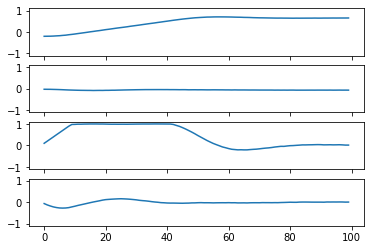

In [22]:
def plot_episode(episode: list):\

    next_observations = [step[3] for step in episode]
    state_dim = len(next_observations[0])
    fig, ax = plt.subplots(state_dim, sharex=True, sharey=True)
    plt.ylim(-1.1, 1.1)
    for i in range(state_dim):
        ax[i].plot([o[i] for o in next_observations])
    plt.show()

plot_episode(episode)


In [25]:
def make_predictions(episode, transitionnet, h: int = 100):\

    n = len(episode)
    observations = torch.stack([step[0] for step in episode]).unsqueeze(0).transpose(0, 1)
    actions = torch.stack([step[2] for step in episode]).unsqueeze(0).transpose(0, 1)
    d = observations.shape[-1]
    predictions = torch.zeros((n, h, d))

    hidden_state = None
    for i in range(n):
        current_observation = observations[i]
        transitionnet.update_state(hidden_state)
        mu_pred, logvar_pred = transitionnet(observations[i], actions[i])
        hidden_state = transitionnet.get_state()
        delta_pred = rp(mu_pred, logvar_pred)
        state_pred = current_observation + delta_pred

        predictions[i, 0] = state_pred
        for j in range(1, h):
            if i+j >= n:
                break
            mu_pred, logvar_pred = transitionnet(state_pred, actions[i+j])
            delta_pred = rp(mu_pred, logvar_pred)
            state_pred = state_pred + delta_pred

            predictions[i, j] = state_pred

    return predictions

predictions = make_predictions(episode, transitionnet, h=50)

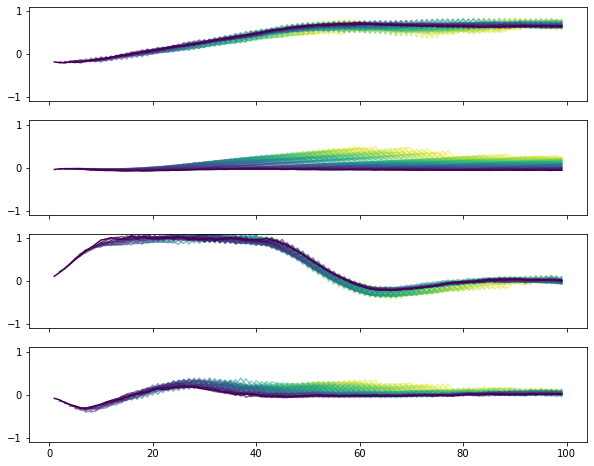

In [26]:
def plot_predictions(predictions):\

    n, h, d = predictions.shape
    predictions = predictions.detach().numpy()
    fig, ax = plt.subplots(d, figsize=(10, 8), sharex=True, sharey=True)
    plt.ylim(-1.1, 1.1)
    for i in range(d):
        for j in np.arange(h, 0, -1):
            idx = np.arange(0., 1., 1./h)[j-1]
            ax[i].plot(np.arange(j, n), predictions[:-j,j-1,i],
                       c=cm.viridis(idx), alpha=0.5 + 0.5 / j)

    plt.show()

plot_predictions(predictions)

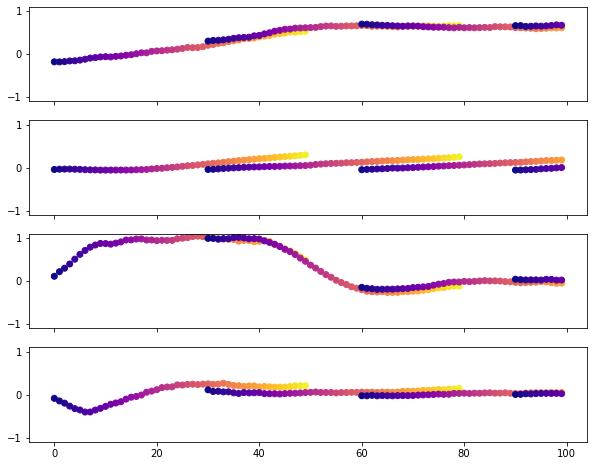

In [36]:
def plot_predictions2(predictions):\

    n, h, d = predictions.shape
    predictions = predictions.detach().numpy()
    fig, ax = plt.subplots(d, figsize=(10, 8), sharex=True, sharey=True)
    plt.ylim(-1.1, 1.1)
    for i in range(d):
        for j in np.arange(0, n, 30):
            max_ = np.min([h, n-j])
            idx = np.arange(0., 1., 1./(h))
            ax[i].scatter(np.arange(j, np.min([j+h, n])), predictions[j, :max_, i], c=cm.plasma(idx[:max_]))#, cmap='plasma')

    plt.show()

plot_predictions2(predictions)

In [15]:
def make_animation(episode, transitionnet, h: int = 100, fps: float = 50.):\

    predictions = make_predictions(episode, transitionnet, h)
    predictions = predictions.detach().numpy()
    next_observations = [step[3] for step in episode]

    n, h, d = predictions.shape

    fig, ax = plt.subplots(d, figsize=(8, 6), sharex=True, sharey=True)
    plt.ylim(-1.1, 1.1)
    camera = Camera(fig)
             
    # make an initial snapshot without prediction
    for i in range(d):
        ax[i].plot([o[i] for o in next_observations], c='g')
    camera.snap()

    # animate the prediction
    for t in np.arange(0, n):
        for i in range(d):
            max = np.min([h, n-t])
            idx = np.arange(0., 1., 1./(h))
            ax[i].scatter(np.arange(t, np.min([t+h, n])), predictions[t, :max, i], c=idx[:max], cmap='plasma')
            ax[i].plot([o[i] for o in next_observations], c='g')
        
        camera.snap()

    animation = camera.animate(interval=1000./fps)
    plt.close()

    return animation

animation = make_animation(episode, transitionnet, h=50)
animation.save('animation.mp4')
HTML(animation.to_html5_video())

In [ ]:

    mu_predicted_delta_state, logvar_predicted_delta_state = transitionnet(observation, action)
    predicted_delta_state = rp(mu_predicted_delta_state, logvar_predicted_delta_state)
    predicted_state = observation + predicted_delta_state
    prediction_error = torch.mean(0.5 * (predicted_state - next_observation)**2)
    prediction_errors.append(prediction_error.detach())
